                                club_names
0                     Fulham Football Club
1                    Everton Football Club
2          Manchester United Football Club
3                    Arsenal Football Club
4                    Chelsea Football Club
5    Wolverhampton Wanderers Football Club
9                           Leicester City
11               Aston Villa Football Club
12                            Leeds United
13           Manchester City Football Club
15                 Brentford Football Club
16                          Southampton FC
17         Nottingham Forest Football Club
20           West Ham United Football Club
21          Newcastle United Football Club
26                 Liverpool Football Club
27   Association Football Club Bournemouth
31  Brighton and Hove Albion Football Club
32         Tottenham Hotspur Football Club
47            Crystal Palace Football Club 

Nombre del equipo: Manchester United Football Club y su id: 985 

Fitting 5 folds for each of 1

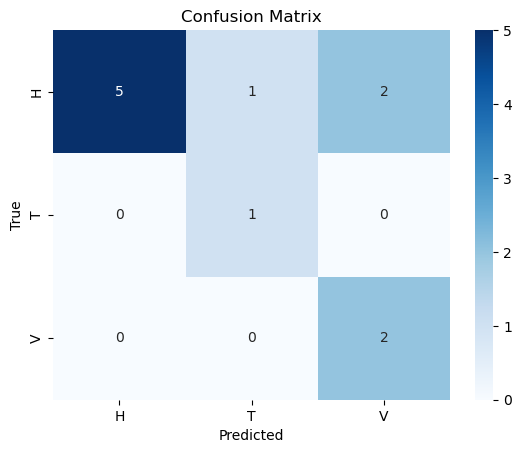

                                Feature  Importance
3   home_club_position_label_Relegation    0.231728
8         home_club_formation_label_3_D    0.138314
1       home_club_position_label_Europe    0.124029
15              attendance_label_Medium    0.120346
5       away_club_position_label_Europe    0.091604
12        away_club_formation_label_4_D    0.060572
18                         hosting_Home    0.060388
17                         hosting_Away    0.051994
9         home_club_formation_label_4_D    0.038043
2      home_club_position_label_Nothing    0.035235
14               attendance_label_Large    0.025117
7   away_club_position_label_Relegation    0.022631


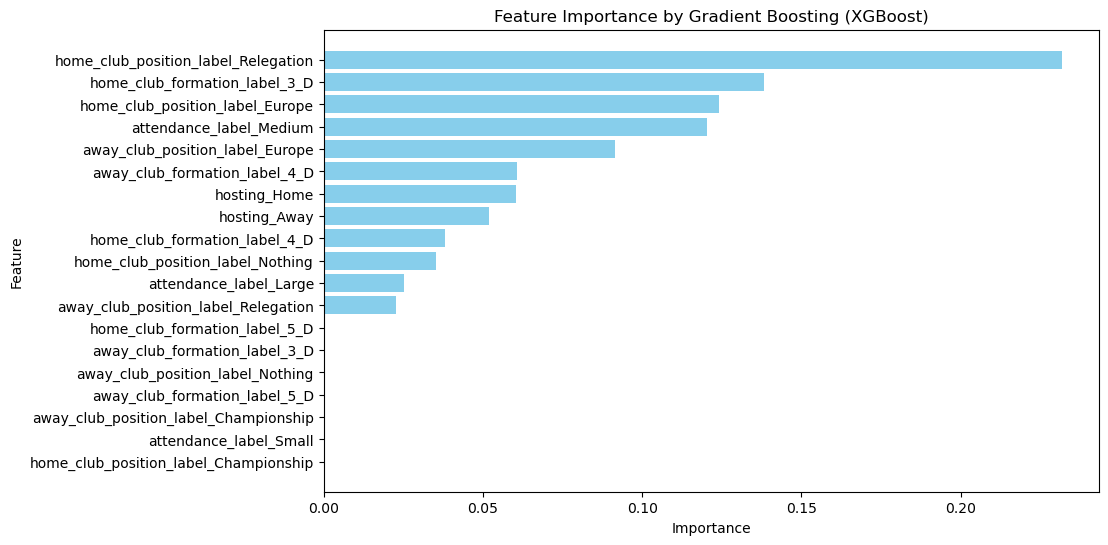

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

def assign_attendance_label(attendance):
    if attendance > 45000:
        return 'Large'
    elif 20000 <= attendance < 45000:
        return 'Medium'
    elif attendance < 20000:
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):
        return '4_D'
    elif formation.startswith('3'):
        return '3_D'
    elif formation.startswith('5'):
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None
    
def printer_home(label, proba, team_name):
            if label == 'H':
                print(f"Victoria de {team_name}: {proba:.2f}%")
            elif label == 'T':
                print(f"Empate : {proba:.2f}%")
            else:
                print(f"Derrota de {team_name}: {proba:.2f}%")

def printer_visitor(label, proba, team_name):
            if label == 'V':
                print(f"Victoria de {team_name}: {proba:.2f}%")
            elif label == 'T':
                print(f"Empate : {proba:.2f}%")
            else:
                print(f"Derrota de {team_name}: {proba:.2f}%")


club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')

games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 28

filtered_games = games_data[
    (games_data['season'] == season) &
    (games_data['competition_id'] == 'GB1') &
    (games_data['competition_type'] == 'domestic_league')
].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

print(filtered_teams, '\n')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

filtered_games['result'] = filtered_games.apply(
    lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)

filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)

filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 
                   'attendance_label', 'home_club_position_label', 'away_club_position_label',
                   'home_club_formation_label', 'away_club_formation_label', 'hosting', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)

smote = SMOTE(random_state=42, k_neighbors=2)


X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train_encoded)

xgb_model = XGBClassifier(verbosity=1) 

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train_balanced, y_train_balanced)

best_xgb_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)]['result']
X_test_encoded = encoder.transform(test_data)


if not test_data.empty:
    y_pred_encoded = best_xgb_model.predict(X_test_encoded)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_proba = best_xgb_model.predict_proba(X_test_encoded)


    print(f"\nPredicción para los partidos de {team_name} a partir de la jornada: {matchDay}:") 
    print(f"Número de partidos a predecir: {len(test_data)}")
    print(f"Número de predicciones: {len(y_pred)}")

    class_labels = label_encoder.inverse_transform(best_xgb_model.classes_)

    for idx in range(len(test_data)):
        row = test_data.iloc[idx]
  
        print('\n')
        print("Resultado predicho:", y_pred[idx], "para la jornada ",matchDay+ idx )

    
        proba_percentages = y_proba[idx] * 100

        for label, proba in zip(class_labels, proba_percentages):
            if row['hosting'] == 'Home':
                printer_home(label, proba, team_name)
            elif row['hosting'] == 'Away':
                printer_visitor(label, proba, team_name)
            else: 
                print('Fallo en la detección del local')
    

   
    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(test_data_result.values, columns=['y_test']))

    
    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(test_data_result, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(test_data_result, y_pred):.2f}")


    cm = confusion_matrix(
        test_data_result,
        y_pred,
        labels=class_labels
    )

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} a partir de la jornada: {matchDay}")



feature_importance = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': encoder.get_feature_names_out(X_train.columns),
    'Importance': feature_importance
})

feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_sorted.head(12))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Gradient Boosting (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

                                club_names
0                     Fulham Football Club
1                    Everton Football Club
2          Manchester United Football Club
3                    Arsenal Football Club
4                    Chelsea Football Club
5    Wolverhampton Wanderers Football Club
9                           Leicester City
11               Aston Villa Football Club
12                            Leeds United
13           Manchester City Football Club
15                 Brentford Football Club
16                          Southampton FC
17         Nottingham Forest Football Club
20           West Ham United Football Club
21          Newcastle United Football Club
26                 Liverpool Football Club
27   Association Football Club Bournemouth
31  Brighton and Hove Albion Football Club
32         Tottenham Hotspur Football Club
47            Crystal Palace Football Club 

Nombre del equipo: Manchester United Football Club y su id: 985 

Fitting 5 folds for each of 1

c:\Users\ivizq\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ivizq\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ivizq\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ivizq\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ivizq\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wina

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50,

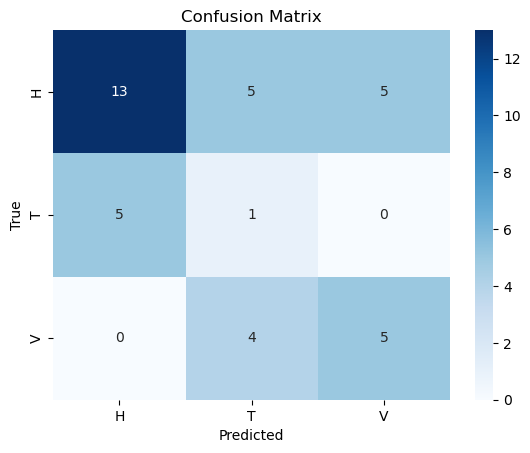

                                  Feature  Importance
3     home_club_position_label_Relegation    0.105870
4   away_club_position_label_Championship    0.095814
7     away_club_position_label_Relegation    0.083699
0   home_club_position_label_Championship    0.078531
5         away_club_position_label_Europe    0.056220
19                           hosting_Home    0.054185
2        home_club_position_label_Nothing    0.052614
6        away_club_position_label_Nothing    0.043200
17                  attendance_label_None    0.042997
13          away_club_formation_label_5_D    0.041741
15                attendance_label_Medium    0.039686
12          away_club_formation_label_4_D    0.038996


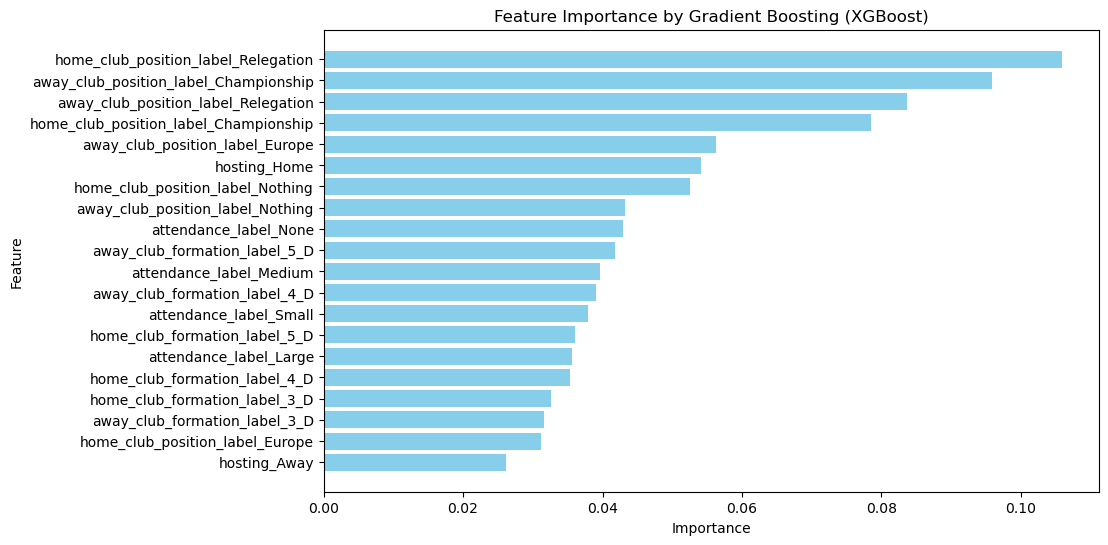

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

def assign_attendance_label(attendance):
    if attendance > 45000:
        return 'Large'
    elif 20000 <= attendance < 45000:
        return 'Medium'
    elif attendance < 20000:
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):
        return '4_D'
    elif formation.startswith('3'):
        return '3_D'
    elif formation.startswith('5'):
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None
    
def printer_home(label, proba, team_name):
            if label == 'H':
                print(f"Victoria de {team_name}: {proba:.2f}%")
            elif label == 'T':
                print(f"Empate : {proba:.2f}%")
            else:
                print(f"Derrota de {team_name}: {proba:.2f}%")

def printer_visitor(label, proba, team_name):
            if label == 'V':
                print(f"Victoria de {team_name}: {proba:.2f}%")
            elif label == 'T':
                print(f"Empate : {proba:.2f}%")
            else:
                print(f"Derrota de {team_name}: {proba:.2f}%")


club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))


filtered_games = games_data[
    (games_data['season'] >= 2019) &
    (games_data['competition_id'] == 'GB1') &
    (games_data['competition_type'] == 'domestic_league')
].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['season'] == season]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([selected_games['home_club_name'], selected_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

print(filtered_teams, '\n')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = selected_games.loc[selected_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

filtered_games['result'] = filtered_games.apply(
    lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)

filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)

filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

selected_games = filtered_games[filtered_games['season'] < season]

merged_club_games = club_games_data.merge(club_data, on='club_id')
selected_games = merged_club_games.merge(selected_games, on='game_id')

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 
                   'attendance_label', 'home_club_position_label', 'away_club_position_label',
                   'home_club_formation_label', 'away_club_formation_label', 'hosting', 'result', 'season']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

filtered_games = filtered_games[filtered_games['season'] == season]
features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = selected_games
X_train = train_data[features]
y_train = train_data['result']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)


smote = SMOTE(random_state=42, k_neighbors=2)


X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train_encoded)


xgb_model = XGBClassifier(verbosity=1) 

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train_balanced, y_train_balanced)

best_xgb_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id))][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id))]['result']
X_test_encoded = encoder.transform(test_data)


if not test_data.empty:
    y_pred_encoded = best_xgb_model.predict(X_test_encoded)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_proba = best_xgb_model.predict_proba(X_test_encoded)


    print(f"\nPredicción para los partidos de {team_name} de la temporada {season}:") 
    print(f"Número de partidos a predecir: {len(test_data)}")
    print(f"Número de predicciones: {len(y_pred)}")

    class_labels = label_encoder.inverse_transform(best_xgb_model.classes_)

    for idx in range(len(test_data)):
        row = test_data.iloc[idx]
  
        print('\n')
        print("Resultado predicho:", y_pred[idx], "para la jornada ", idx +1 )

    
        proba_percentages = y_proba[idx] * 100

        for label, proba in zip(class_labels, proba_percentages):
            if row['hosting'] == 'Home':
                printer_home(label, proba, team_name)
            elif row['hosting'] == 'Away':
                printer_visitor(label, proba, team_name)
            else: 
                print('Fallo en la detección del local')
    

 
    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(test_data_result.values, columns=['y_test']))

    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(test_data_result, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(test_data_result, y_pred):.2f}")

    cm = confusion_matrix(
        test_data_result,
        y_pred,
        labels=class_labels
    )

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} de la temporada {season}")



feature_importance = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': encoder.get_feature_names_out(X_train.columns),
    'Importance': feature_importance
})

feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_sorted.head(12))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Gradient Boosting (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

Index(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type'],
      dtype='object')
                                club_names
0                     Fulham Football Club
1                    Everton Football Club
2          Manchester United Football Club
3                    Arsenal Football Club
4                    Chelsea Football Club
5    Wolverhampton Wanderers Football Club
9                           Leicester City
11               Aston Villa Football Club
12                            Leeds United
13           Manchester City Football Club
15                 Brentford Football Club
16                          Southampton

c:\Users\ivizq\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

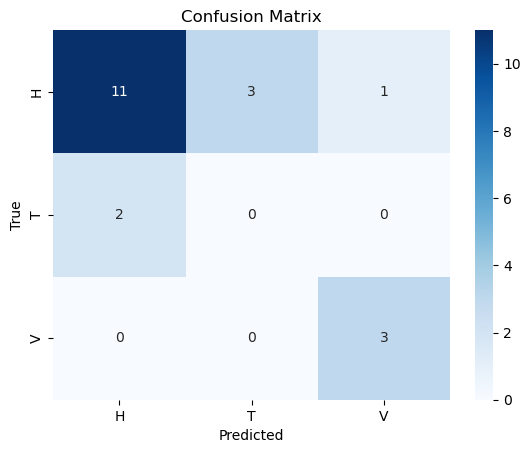

                                  Feature  Importance
13                attendance_label_Medium    0.267298
5         away_club_position_label_Europe    0.219534
3     home_club_position_label_Relegation    0.140443
6     away_club_position_label_Relegation    0.123568
1         home_club_position_label_Europe    0.119383
12                 attendance_label_Large    0.051259
15                           hosting_Away    0.042565
2        home_club_position_label_Nothing    0.035950
0   home_club_position_label_Championship    0.000000
11          away_club_formation_label_4_D    0.000000
14                 attendance_label_Small    0.000000
8           home_club_formation_label_4_D    0.000000


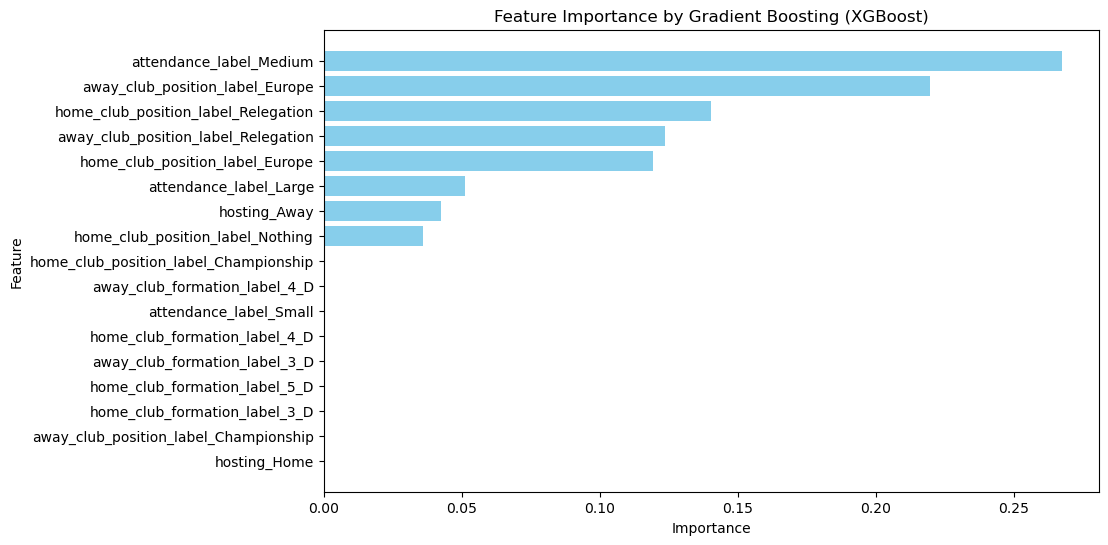

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

def assign_attendance_label(attendance):
    if attendance > 45000:
        return 'Large'
    elif 20000 <= attendance < 45000:
        return 'Medium'
    elif attendance < 20000:
        return 'Small'
    else:
        return None

def assign_formation_label(formation):
    if formation.startswith('4'):
        return '4_D'
    elif formation.startswith('3'):
        return '3_D'
    elif formation.startswith('5'):
        return '5_D'
    else:
        return None

def assign_position_label(position):
    if position <= 2:
        return 'Championship'
    elif 3 <= position <= 9:
        return 'Europe'
    elif 10 <= position <= 14:
        return 'Nothing'
    elif 15 <= position <= 20:
        return 'Relegation'
    else:
        return None
    
def printer_home(label, proba, team_name):
            if label == 'H':
                print(f"Victoria de {team_name}: {proba:.2f}%")
            elif label == 'T':
                print(f"Empate : {proba:.2f}%")
            else:
                print(f"Derrota de {team_name}: {proba:.2f}%")

def printer_visitor(label, proba, team_name):
            if label == 'V':
                print(f"Victoria de {team_name}: {proba:.2f}%")
            elif label == 'T':
                print(f"Empate : {proba:.2f}%")
            else:
                print(f"Derrota de {team_name}: {proba:.2f}%")


club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')
games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


season = int(input("Ingresa la temporada a buscar (2023 para la 23/24, 2022 para 22/23): "))
matchDay = 19

filtered_games = games_data[
    (games_data['season'] == season) &
    (games_data['competition_id'] == 'GB1') &
    (games_data['competition_type'] == 'domestic_league')
].copy()

filtered_games['round'] = filtered_games['round'].str.replace(r'\D+', '', regex=True).astype(int)
selected_games = filtered_games[filtered_games['round'] == matchDay]

filtered_teams = pd.DataFrame({
    'club_names': pd.concat([filtered_games['home_club_name'], filtered_games['away_club_name']], ignore_index=True)
}).drop_duplicates(subset='club_names', keep='first')

print(filtered_games.columns)
print(filtered_teams, '\n')

selected_index = int(input("Ingresa el índice del equipo que deseas seleccionar: "))
selected_team = filtered_teams.loc[selected_index]

if not selected_team.empty:
    team_name = selected_team['club_names']
    team_id = filtered_games.loc[filtered_games['home_club_name'] == team_name, 'home_club_id'].drop_duplicates(keep='first').iloc[0]
    print(f"Nombre del equipo: {team_name} y su id: {team_id} \n")
else:
    print("No se encontró un equipo con el índice proporcionado.\n")

filtered_games['result'] = filtered_games.apply(
    lambda row: 'H' if row['home_club_goals'] > row['away_club_goals'] else 
                ('T' if row['home_club_goals'] == row['away_club_goals'] else 'V'), axis=1)

filtered_games['home_club_position_label'] = filtered_games['home_club_position'].apply(assign_position_label)
filtered_games['away_club_position_label'] = filtered_games['away_club_position'].apply(assign_position_label)

filtered_games['home_club_formation_label'] = filtered_games['home_club_formation'].apply(assign_formation_label)
filtered_games['away_club_formation_label'] = filtered_games['away_club_formation'].apply(assign_formation_label)

filtered_games['attendance_label'] = filtered_games['attendance'].apply(assign_attendance_label)

team_home_games = filtered_games[filtered_games['home_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Home') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

team_away_games = filtered_games[filtered_games['away_club_name'] == team_name].merge(
    club_games_data[(club_games_data['hosting'] == 'Away') & (club_games_data['club_id'] == team_id)],
    on='game_id', how='inner')

columns_to_keep = ['game_id', 'home_club_name', 'away_club_name', 'home_club_id', 'away_club_id', 'round', 
                   'attendance_label', 'home_club_position_label', 'away_club_position_label',
                   'home_club_formation_label', 'away_club_formation_label', 'hosting', 'result']

team_home_games = team_home_games[columns_to_keep]
team_away_games = team_away_games[columns_to_keep]
filtered_games = pd.concat([team_home_games, team_away_games])

filtered_games = filtered_games.sort_values(by='round').reset_index(drop=True)

features = ['home_club_position_label', 'away_club_position_label', 'home_club_formation_label', 
            'away_club_formation_label', 'attendance_label', 'hosting']

train_data = filtered_games[filtered_games['round'] < matchDay]
X_train = train_data[features]
y_train = train_data['result']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)

xgb_model = XGBClassifier(verbosity=1) 

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train_encoded, y_train_encoded)

best_xgb_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

test_data = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)][features]
test_data_result = filtered_games[((filtered_games['home_club_id'] == team_id) | (filtered_games['away_club_id'] == team_id)) & 
                           (filtered_games['round'] >= matchDay)]['result']
X_test_encoded = encoder.transform(test_data)


if not test_data.empty:
    y_pred_encoded = best_xgb_model.predict(X_test_encoded)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_proba = best_xgb_model.predict_proba(X_test_encoded)


    print(f"\nPredicción para los partidos de {team_name} a partir de la jornada: {matchDay}:") 
    print(f"Número de partidos a predecir: {len(test_data)}")
    print(f"Número de predicciones: {len(y_pred)}")

    class_labels = label_encoder.inverse_transform(best_xgb_model.classes_)

    for idx in range(len(test_data)):
        row = test_data.iloc[idx]
  
        print('\n')
        print("Resultado predicho:", y_pred[idx], "para la jornada ",matchDay+ idx )

    
        proba_percentages = y_proba[idx] * 100

        for label, proba in zip(class_labels, proba_percentages):
            if row['hosting'] == 'Home':
                printer_home(label, proba, team_name)
            elif row['hosting'] == 'Away':
                printer_visitor(label, proba, team_name)
            else: 
                print('Fallo en la detección del local')
    

 
    print("\nValores predichos en el conjunto de prueba (y_pred):")
    print(pd.DataFrame(y_pred, columns=['y_pred']))

    print("\nValores verdaderos en el conjunto de prueba (y_test):")
    print(pd.DataFrame(test_data_result.values, columns=['y_test']))


    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_report(test_data_result, y_pred))

    print("\nPrecisión en el conjunto de prueba:")
    print(f"Accuracy en prueba: {accuracy_score(test_data_result, y_pred):.2f}")

    cm = confusion_matrix(
        test_data_result,
        y_pred,
        labels=class_labels
    )

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

else:
    print(f"No hay partidos disponibles para {team_name} a partir de la jornada: {matchDay}")



feature_importance = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': encoder.get_feature_names_out(X_train.columns),
    'Importance': feature_importance
})

feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_sorted.head(12))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Gradient Boosting (XGBoost)')
plt.gca().invert_yaxis()
plt.show()